# Модуль посвящен обучению модели и ее инференсу.


Обучать будет классификацию и регрессию. Обычно в 3 модулю как раз несколько задач.

# Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

import joblib

# Импорт данных

Мы предобрабатывали данные в предыдущих модулях, поэтому с данными работаем минимально.

In [2]:
df = pd.read_parquet('data/data.parquet')

df.head()

,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,325.0,21.1,2.5,35.0,15.4,15.6,20.483337
1,369.0,20.8,2.7,35.0,15.1,15.3,20.425000
2,419.0,20.4,3.0,34.0,15.6,15.8,20.333332
3,451.0,20.5,3.1,33.0,16.4,16.6,20.258335
4,458.0,22.1,3.0,29.0,17.7,17.8,20.316668


In [3]:
X = df.drop(['AQI'], axis=1)
y = df['AQI']

In [4]:
# Отмасштабируем признаки

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Модель регресии

## Обучение моделей


Для обучения регрессии берем 3 модели: Линейную регрессию, Градиентный бустинг (или Случайный лес) и нейронную сеть (в критериях может быть отдельно использование нейронки, поэтому берем всегда).


Такой набор моделей объясняется их разноплановостью, что лучше скажется на итоговом результате.

### Линейная регрессия

In [6]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

### Градиентный бустинг

In [7]:
model_cb = CatBoostRegressor(
    verbose=0,
    # task_type='GPU'
)

model_cb.fit(X_train, y_train)
y_pred_cb = model_cb.predict(X_test)

### Нейронная сеть

In [8]:
model_nn = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    max_iter=1000,
    random_state=42
)

model_nn.fit(X_train, y_train)
y_pred_nn = model_nn.predict(X_test)

## Метрики качества регрессии

1. MAE — Mean Absolute Error


2. RMSE — Root Mean Squared Error


3. R² — коэффициент детерминации

In [9]:
print('MAE - чем меньше, тем лучше')
print(f'MAE для LinearRegression: {mean_absolute_error(y_test, y_pred_lr):.3f}')
print(f'MAE для CatBoostRegressor: {mean_absolute_error(y_test, y_pred_cb):.3f}')
print(f'MAE для MLPRegressor: {mean_absolute_error(y_test, y_pred_nn):.3f}')

MAE - чем меньше, тем лучше
MAE для LinearRegression: 7.350
MAE для CatBoostRegressor: 4.379
MAE для MLPRegressor: 4.748


In [10]:
print('RMSE - чем меньше, тем лучше')
print(f'RMSE для LinearRegression: {root_mean_squared_error(y_test, y_pred_lr):.3f}')
print(f'RMSE для CatBoostRegressor: {root_mean_squared_error(y_test, y_pred_cb):.3f}')
print(f'RMSE для MLPRegressor: {root_mean_squared_error(y_test, y_pred_nn):.3f}')

RMSE - чем меньше, тем лучше
RMSE для LinearRegression: 10.205
RMSE для CatBoostRegressor: 7.368
RMSE для MLPRegressor: 7.752


In [11]:
print('R2 - чем выше, тем лучше')
print(f'R2 для LinearRegression: {r2_score(y_test, y_pred_lr):.3f}')
print(f'R2 для CatBoostRegressor: {r2_score(y_test, y_pred_cb):.3f}')
print(f'R2 для MLPRegressor: {r2_score(y_test, y_pred_nn):.3f}')

R2 - чем выше, тем лучше
R2 для LinearRegression: 0.798
R2 для CatBoostRegressor: 0.895
R2 для MLPRegressor: 0.884


Лучшеми моделями стала CatBoostRegressor и Нейронная сеть, подберем гиперпараметры для них с помощью RandomizedSearchCV.

## Catboost с подобранными гиперпараметрами.

Для подбора гиперпараметров Catboost нужно откатиться до scikit-learn==1.5.2

Если возникают проблемы, можно просто заменить модель Catboost на RandomForest, с ним таких проблем не будет.

Однако, для начала лучше попробовать градиентный бустинг, так как он выдает обычно качество лучше.

In [14]:
!pip install scikit-learn==1.5.2 -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
param_dist_cb = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "iterations": [300, 500, 800],
    "l2_leaf_reg": [1, 3, 5, 7, 9]
}

cb = CatBoostRegressor(verbose=0,
                      # task_type='GPU'
                      )

random_cb = RandomizedSearchCV(
    cb,
    param_distributions=param_dist_cb,
    cv=3,
    # n_jobs=-1,
    verbose=1,
    n_iter=3
)

random_cb.fit(X_train, y_train)

best_cb = random_cb.best_estimator_
y_pred_cb = best_cb.predict(X_test)

print(f'MAE для CatBoostRegressor: {mean_absolute_error(y_test, y_pred_cb):.3f}')
print(f'RMSE для CatBoostRegressor: {root_mean_squared_error(y_test, y_pred_cb):.3f}')
print(f'R2 для CatBoostRegressor: {r2_score(y_test, y_pred_cb):.3f}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
MAE для CatBoostRegressor: 4.571
RMSE для CatBoostRegressor: 7.594
R2 для CatBoostRegressor: 0.888


## Нейронная сеть с подобранными гиперпараметрами.

In [18]:
param_grid_nn = {
    "hidden_layer_sizes": [(32, ), (64, ), (64, 32), (128, 64), (128, 128)],
    "activation": ["relu", "tanh"],
    "learning_rate_init": [0.001, 0.005, 0.01]
}

model_nn = MLPRegressor()


random_nn = RandomizedSearchCV(
    model_nn,
    param_distributions=param_grid_nn,
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=3
)

random_nn.fit(X_train, y_train)

best_nn = random_nn.best_estimator_
y_pred_nn = best_nn.predict(X_test)

print(f'MAE для MLPRegressor: {mean_absolute_error(y_test, y_pred_nn):.3f}')
print(f'RMSE для MLPRegressor: {root_mean_squared_error(y_test, y_pred_nn):.3f}')
print(f'R2 для MLPRegressor: {r2_score(y_test, y_pred_nn):.3f}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
MAE для MLPRegressor: 4.707
RMSE для MLPRegressor: 7.506
R2 для MLPRegressor: 0.891


E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Лучшей моделью стала CatboostRegressor с подобранными гиперпараметрами. Визуализируем прогноз модели с фактическими данными.

## Визуализация предсказаний


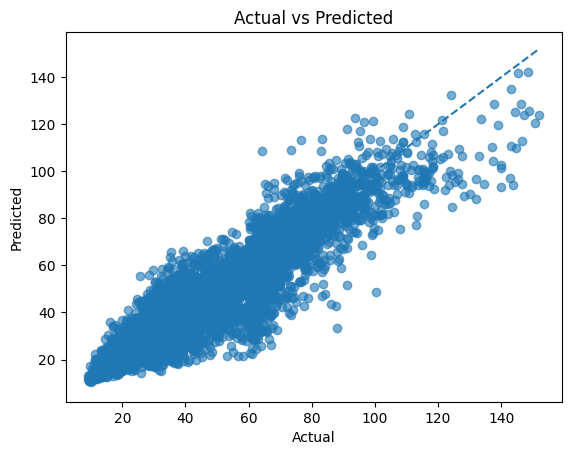

In [19]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_cb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

В целом по графику видна отличная корреляция между предсказанием и реальнами данными.

## Сохранение моделей классификации

Для сохранения моделей sklearn используем библиотеку joblib. Хотя для catboost-моделей этот метод тоже подходит, лучше сохранить модель собственными методами.

In [21]:
best_cb.save_model('catboost_model_regression.cbm', format='cbm')

joblib.dump(best_nn, 'nn_model_regression.pkl');

## Функция для дообучения

Часто на чемпионатах просят организовать непрерывное обучение моделей с помощью AirFlow. 

Создадим функцию для дообучения моделей, которую можно будет перенести в Airflow или интерфейс в будущем.

In [26]:
def fine_tuning_regression(new_data: pd.DataFrame) -> None:

    # Загрузка моделей
    nn_model = joblib.load('nn_model_regression.pkl')
    cb_model = CatBoostRegressor().load_model('catboost_model_regression.cbm')

    # Отмастабируем признаки
    scaler = StandardScaler()
    X = new_data.drop(['AQI'], axis=1)
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = new_data['AQI']

    # Дообучение моделей
    nn_model.fit(X, y)
    cb_model.fit(X, y)

    # Инфренс на тесте (тут, скорее всего, будет тестовый датасет, но для демонстрации берем наш основной датасет)
    test = pd.read_parquet('data/data.parquet')
    X_test = test.drop(['AQI'], axis=1)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    y_test = test['AQI']

    y_pred_nn = nn_model.predict(X_test)
    y_pred_cb = cb_model.predict(X_test)
    
    # Вычисляем метрики после дообучения

    # Вычисляем метрики для MLPRegressor
    mae_mlp = mean_absolute_error(y_test, y_pred_nn)
    rmse_mlp = root_mean_squared_error(y_test, y_pred_nn)
    r2_mlp = r2_score(y_test, y_pred_nn)
    
    # Вычисляем метрики для CatBoostRegressor
    mae_cb = mean_absolute_error(y_test, y_pred_cb)
    rmse_cb = root_mean_squared_error(y_test, y_pred_cb)
    r2_cb = r2_score(y_test, y_pred_cb)

    # Формируем словарь с результатами
    results = {
        'MLPRegressor': {
            'MAE': round(mae_mlp, 3),
            'RMSE': round(rmse_mlp, 3),
            'R2': round(r2_mlp, 3)
        },
        'CatBoostRegressor': {
            'MAE': round(mae_cb, 3),
            'RMSE': round(rmse_cb, 3),
            'R2': round(r2_cb, 3)
        }
    }

    # Сохранение обновленных моделей
    cb_model.save_model('catboost_model_regression.cbm', format='cbm')
    joblib.dump(nn_model, 'nn_model_regression.pkl')
    
    return results

In [27]:
# Проверяем функцию

new_data = X_test.copy()
new_data['AQI'] = y_test

fine_tuning_regression(new_data)

E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'MLPRegressor': {'MAE': 4.688, 'RMSE': 7.672, 'R2': 0.886},
 'CatBoostRegressor': {'MAE': 4.589, 'RMSE': 7.617, 'R2': 0.888}}

# Модель классификации

## Предобработка данных

In [62]:
# Превращаем регрессию в классификацию
# y — регрессионный таргер
# labels = ["low", "medium", "high"]
bins = np.quantile(y, [0, 0.22, 0.89, 1.0])
labels = [0, 1, 2]

y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True)

Видим, что классы несбалансированны, класс 1 в 6 раз больше чем класс 2.

In [63]:
y_class.value_counts(normalize=True) * 100

AQI
1    66.352740
0    22.648402
2    10.998858
Name: proportion, dtype: float64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

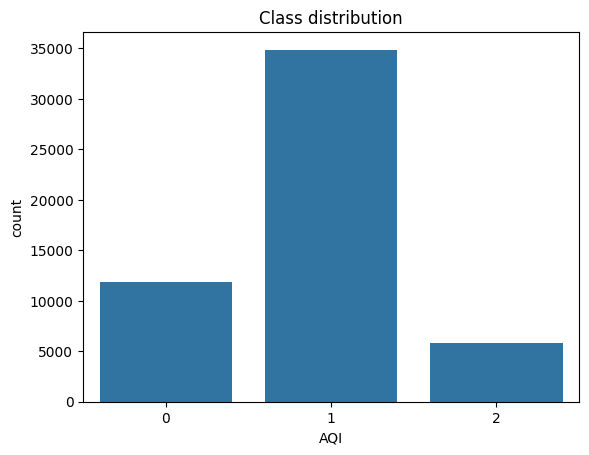

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_class)
plt.title("Class distribution")
plt.show()

## Устранение дисбаланса

Для устранения дисбаланса используем метод SMOTE, он создаст синтетические новые примеры для редкого класса в нашем датасете.


Делает это так:

1. выбирает случайный объект редкого класса

2. выбирает его соседей

3. интерполирует (генерирует точки между ними)

In [32]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

После генерации проверим данные на сбалансированность классов.

In [33]:
y_train_resampled.value_counts(normalize=True) * 100

AQI
0    33.333333
1    33.333333
2    33.333333
Name: proportion, dtype: float64

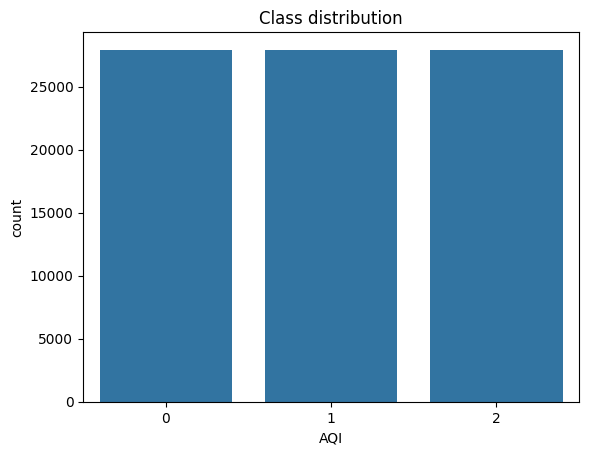

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train_resampled)
plt.title("Class distribution")
plt.show()

Видим, что после использования метода SMOTE баланс идеален, что поможет лучше обучить модель и вычислить метрики.

## Обучение моделей

Аналогично регрессии, берем разностороние методы классификации.

### Логистическая регрессия

In [35]:
log_reg = LogisticRegression()

log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_lr = log_reg.predict(X_test)

### Градиентный бустинг

In [36]:
cb = CatBoostClassifier(verbose=0)

cb.fit(X_train_resampled, y_train_resampled)
y_pred_cb = cb.predict(X_test)

### Нейронная сеть

In [37]:
nn = MLPClassifier()

nn.fit(X_train_resampled, y_train_resampled)
y_pred_nn = nn.predict(X_test)

E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Метрики качества классификации


Для multi-class классификации, как в нашем случае, подойдут:

- Accuracy

- Precision / Recall / F1 (в среднем)

- ROC/AUC (макро или micro)

- Confusion Matrix

In [38]:
print("Accuracy — чем выше, тем лучше")
print(f"Accuracy для LogisticRegression: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"Accuracy для CatBoostClassifier: {accuracy_score(y_test, y_pred_cb):.3f}")
print(f"Accuracy для MLPClassifier: {accuracy_score(y_test, y_pred_nn):.3f}")

Accuracy — чем выше, тем лучше
Accuracy для LogisticRegression: 0.798
Accuracy для CatBoostClassifier: 0.899
Accuracy для MLPClassifier: 0.882


In [39]:
print("F1 (macro) — чем выше, тем лучше")
print(f"F1-macro для LogisticRegression: {f1_score(y_test, y_pred_lr, average='macro'):.3f}")
print(f"F1-macro для CatBoostClassifier: {f1_score(y_test, y_pred_cb, average='macro'):.3f}")
print(f"F1-macro для MLPClassifier: {f1_score(y_test, y_pred_nn, average='macro'):.3f}")


F1 (macro) — чем выше, тем лучше
F1-macro для LogisticRegression: 0.775
F1-macro для CatBoostClassifier: 0.872
F1-macro для MLPClassifier: 0.852


In [40]:
print("Precision (macro) — чем выше, тем лучше")
print(f"Precision-macro для LogisticRegression: {precision_score(y_test, y_pred_lr, average='macro'):.3f}")
print(f"Precision-macro для CatBoostClassifier: {precision_score(y_test, y_pred_cb, average='macro'):.3f}")
print(f"Precision-macro для MLPClassifier: {precision_score(y_test, y_pred_nn, average='macro'):.3f}")


Precision (macro) — чем выше, тем лучше
Precision-macro для LogisticRegression: 0.738
Precision-macro для CatBoostClassifier: 0.837
Precision-macro для MLPClassifier: 0.814


In [41]:
print("Recall (macro) — чем выше, тем лучше")
print(f"Recall-macro для LogisticRegression: {recall_score(y_test, y_pred_lr, average='macro'):.3f}")
print(f"Recall-macro для CatBoostClassifier: {recall_score(y_test, y_pred_cb, average='macro'):.3f}")
print(f"Recall-macro для MLPClassifier: {recall_score(y_test, y_pred_nn, average='macro'):.3f}")

Recall (macro) — чем выше, тем лучше
Recall-macro для LogisticRegression: 0.851
Recall-macro для CatBoostClassifier: 0.921
Recall-macro для MLPClassifier: 0.915


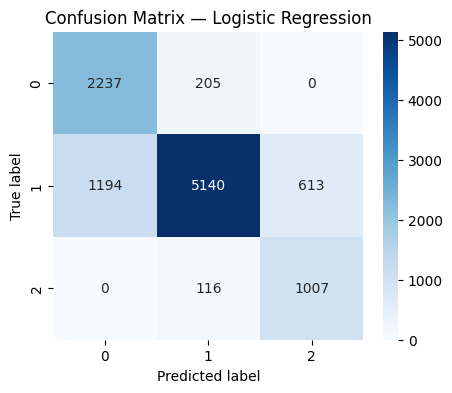

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

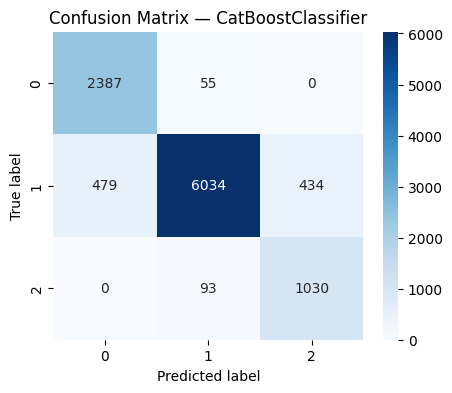

In [43]:
cm_cb = confusion_matrix(y_test, y_pred_cb)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — CatBoostClassifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


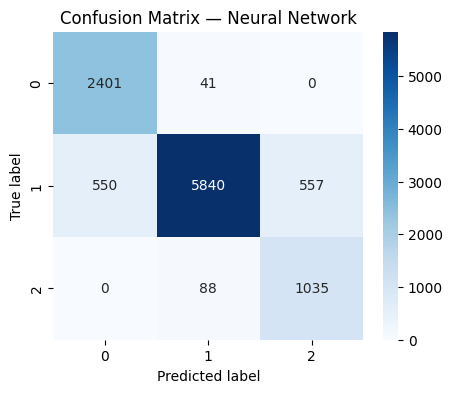

In [44]:
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Neural Network")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


Исходя из метрик, лучшими моделями стали CatboostClassifier и нейронная сеть. Займемся подбором гиперпараметров для этих моделей и сравним их снова.

## CatBoostClassifier с подобранными гиперпараметрами

Для подбора гиперпараметров Catboost нужно откатиться до scikit-learn==1.5.2

Если возникают проблемы, можно просто заменить модель Catboost на RandomForest, с ним таких проблем не будет.

Однако, для начала лучше попробовать градиентный бустинг, так как он выдает обычно качество лучше.

In [43]:
!pip install scikit-learn==1.5.2 -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
param_dist_cb_cls = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "iterations": [300, 500, 800],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
}

cb_cls = CatBoostClassifier(
    verbose=0,
    # task_type='GPU'
)

random_cb_cls = RandomizedSearchCV(
    cb_cls,
    param_distributions=param_dist_cb_cls,
    cv=3,
    # n_jobs=-1,
    verbose=1,
    n_iter=4,
)

random_cb_cls.fit(X_train, y_train)

best_cb_cls = random_cb_cls.best_estimator_
y_pred_cb = best_cb_cls.predict(X_test)
y_proba_cb = best_cb_cls.predict_proba(X_test)

print(f"Accuracy для CatBoostClassifier: {accuracy_score(y_test, y_pred_cb):.3f}")
print(f"F1-macro для CatBoostClassifier: {f1_score(y_test, y_pred_cb, average='macro'):.3f}")
print(f"Precision-macro для CatBoostClassifier: {precision_score(y_test, y_pred_cb, average='macro'):.3f}")
print(f"Recall-macro для CatBoostClassifier: {recall_score(y_test, y_pred_cb, average='macro'):.3f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Accuracy для CatBoostClassifier: 0.920
F1-macro для CatBoostClassifier: 0.893
Precision-macro для CatBoostClassifier: 0.897
Recall-macro для CatBoostClassifier: 0.891


## MLPClassifier с подобранными гиперпараметрами

In [48]:
param_grid_nn_cls = {
    "hidden_layer_sizes": [(64, 32), (128, 64)],
    "activation": ["relu", "tanh"],
    "learning_rate_init": [0.001, 0.01],
}

model_nn_cls = MLPClassifier(
)

random_nn_cls = RandomizedSearchCV(
    model_nn_cls,
    param_distributions=param_grid_nn_cls,
    cv=3,
    # n_jobs=-1,
    verbose=1,
    n_iter=3
)

random_nn_cls.fit(X_train, y_train)

best_nn_cls = random_nn_cls.best_estimator_
y_pred_nn = best_nn_cls.predict(X_test)
y_proba_nn = best_nn_cls.predict_proba(X_test)

print(f"Accuracy для MLPClassifier: {accuracy_score(y_test, y_pred_nn):.3f}")
print(f"F1-macro для MLPClassifier: {f1_score(y_test, y_pred_nn, average='macro'):.3f}")
print(f"Precision-macro для MLPClassifier: {precision_score(y_test, y_pred_nn, average='macro'):.3f}")
print(f"Recall-macro для MLPClassifier: {recall_score(y_test, y_pred_nn, average='macro'):.3f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy для MLPClassifier: 0.912
F1-macro для MLPClassifier: 0.883
Precision-macro для MLPClassifier: 0.878
Recall-macro для MLPClassifier: 0.890


Лучшей моделью с подобранными гиперпараметрами стала CatBoostClassifier, для нее построим ROC-AUC.

## Построение ROC-AUC

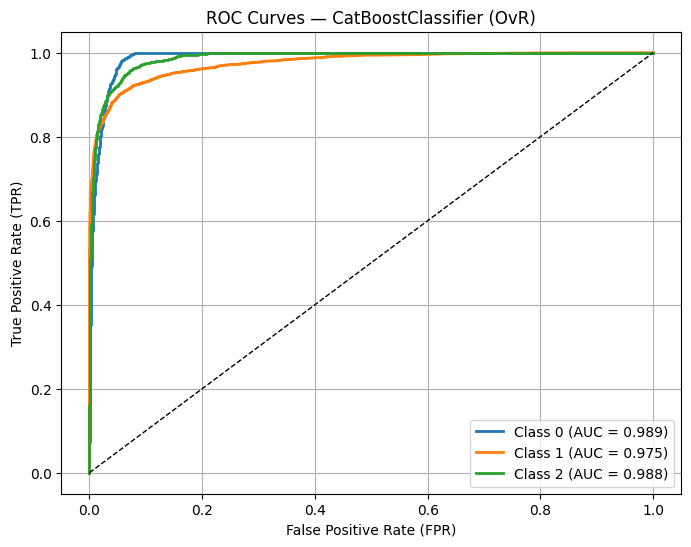

In [49]:
# Массив классов
classes = np.unique(y_test)

# Бинаризуем y_test
y_test_bin = label_binarize(y_test, classes=classes)

# Предсказанные вероятности CatBoost
y_proba = best_cb_cls.predict_proba(X_test)

plt.figure(figsize=(8, 6))

# Построение ROC-кривой для каждого класса по отдельности
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.3f})")

# Линия случайного классификатора
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves — CatBoostClassifier (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Для каждого класса метрика высокая. Модель справляется очень хорошо.

## Распределения вероятностей

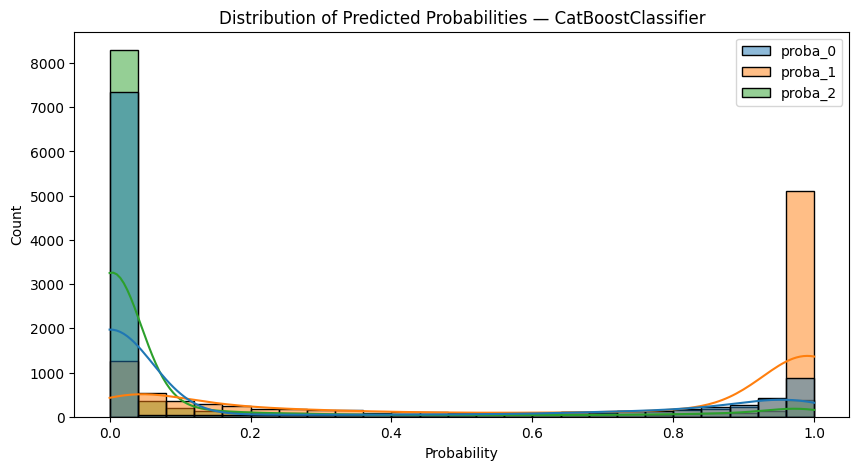

In [50]:
import pandas as pd

proba_df = pd.DataFrame(y_proba, columns=[f"proba_{cls}" for cls in classes])

plt.figure(figsize=(10, 5))
sns.histplot(proba_df, kde=True, bins=25)
plt.title("Distribution of Predicted Probabilities — CatBoostClassifier")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

## Сохранение моделей классификации

Для сохранения моделей sklearn используем библиотеку joblib. Хотя для catboost-моделей этот метод тоже подходит, лучше сохранить модель собственными методами.

In [51]:
best_cb_cls.save_model('catboost_model_classification.cbm', format='cbm')

joblib.dump(best_nn_cls, 'nn_model_classification.pkl')

['nn_model_classification.pkl']

## Функция для дообучения

Часто на чемпионатах просят организовать непрерывное обучение моделей с помощью AirFlow. 

Создадим функцию для дообучения моделей и добавления новых классов, которую можно будет перенести в Airflow или интерфейс в будущем.

In [82]:
def fine_tuning_classification(new_data: pd.DataFrame) -> None:

    # Загрузка моделей
    nn_model = joblib.load('nn_model_classification.pkl')
    cb_model = CatBoostClassifier().load_model('catboost_model_classification.cbm')

    # Отмастабируем признаки
    scaler = StandardScaler()
    X = new_data.drop(['AQI_class'], axis=1)
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = new_data['AQI_class']

    # Дообучение моделей
    nn_model.fit(X, y)
    cb_model.fit(X, y)

    # Инфренс на тесте (тут, скорее всего, будет тестовый датасет, но для демонстрации берем наш основной датасет)
    test = pd.read_parquet('data/data.parquet')
    y_test = test['AQI']
    bins = np.quantile(y_test, [0, 0.22, 0.89, 1.0])
    labels = [0, 1, 2]
    y_test = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)

    scaler = StandardScaler()
    X_test = test.drop(['AQI'], axis=1)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    y_pred_nn = nn_model.predict(X_test)
    y_pred_cb = cb_model.predict(X_test)
    
    # Вычисляем метрики после дообучения
    metrics = {
    "CatBoostClassifier": {
        "Accuracy": round(accuracy_score(y_test, y_pred_cb), 3),
        "F1-macro": round(f1_score(y_test, y_pred_cb, average='macro'), 3),
        "Precision-macro": round(precision_score(y_test, y_pred_cb, average='macro'), 3),
        "Recall-macro": round(recall_score(y_test, y_pred_cb, average='macro'), 3)
    },
    "MLPClassifier": {
        "Accuracy": round(accuracy_score(y_test, y_pred_nn), 3),
        "F1-macro": round(f1_score(y_test, y_pred_nn, average='macro'), 3),
        "Precision-macro": round(precision_score(y_test, y_pred_nn, average='macro'), 3),
        "Recall-macro": round(recall_score(y_test, y_pred_nn, average='macro'), 3)
    }
    }

    # # Сохранение обновленных моделей
    cb_model.save_model('catboost_model_regression.cbm', format='cbm')
    joblib.dump(nn_model, 'nn_model_regression.pkl')
    
    return metrics

In [84]:
# Проверяем функцию

# Имитируем добавление нового класса 3, в реальности просто дадут новые данные
bins = np.quantile(y, [0, 0.22, 0.55, 0.89, 1.0])
labels = [0, 1, 2, 3]

y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
new_data = X_test.copy()
new_data['AQI_class'] = y_class

fine_tuning_classification(new_data)

E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Heckfy\atom\REA\Preparing_Rea2026\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'CatBoostClassifier': {'Accuracy': 0.53,
  'F1-macro': 0.398,
  'Precision-macro': 0.468,
  'Recall-macro': 0.402},
 'MLPClassifier': {'Accuracy': 0.541,
  'F1-macro': 0.405,
  'Precision-macro': 0.469,
  'Recall-macro': 0.408}}